In [1]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command #using the command we can pass the command from one agent to another agent
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

In [2]:
load_dotenv()

True

In [3]:
openai_model=ChatOpenAI(model="gpt-4")

In [55]:
from langchain_groq import ChatGroq
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [5]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-8a69ed08-011b-43f1-81dc-e27476259bc5-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
# this is a dummay example
def add_numbers(state):
    result=state["num1"]+state["num2"]
    print(f"additional result: {result}")
    return Command(goto="multiply",update={"sum":result})

In [7]:
state={"num1":1, "num2":2}

In [8]:
add_numbers(state)

additional result: 3


Command(update={'sum': 3}, goto='multiply')

In [9]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return 

In [10]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return 

In [11]:
model_with_tool=openai_model.bind_tools([transfer_to_multiplication_expert])

In [12]:
ai_message=model_with_tool.invoke("hi how are you?")

In [13]:
ai_message.tool_calls

[]

In [16]:
ai_message=model_with_tool.invoke("what's (3 + 5) Provide me the output")

In [17]:
ai_message.tool_calls

[]

In [18]:
#this is my first agent
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = openai_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [19]:
#this is my second agent
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = openai_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    
    return {"messages": [ai_msg]}

In [20]:
graph=StateGraph(MessagesState)

In [21]:
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)

In [23]:
graph.add_edge(START, "additional_expert")

In [24]:
app=graph.compile()

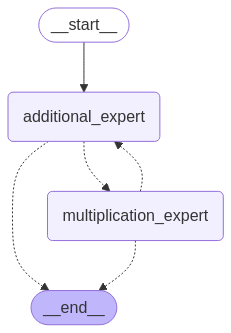

In [25]:
display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='f6acf1d2-4d86-47e4-be88-efd4a697d77a'),
  AIMessage(content="The addition part here is (3 + 5) which equals 8. Now let's move to the multiplication part.", additional_kwargs={'tool_calls': [{'id': 'call_30QPLX97KTsY2TmaXHe4C3KM', 'function': {'arguments': '{\n  "numbers": [8, 12]\n}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 86, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-92d584e2-f182-4895-b7a1-9135f5b8fe50-0', tool_calls=[{'name': 'transfer_to_mu

In [29]:
from langchain_core.messages import convert_to_messages
def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [30]:
# Let's run the graph with an expression that requires both addition and multiplication:
for chunk in app.stream(
    {"messages": [("user", "what's (3 + 5) * 12. Provide me the output")]},
):
    print("****chunk...****")
    
    pretty_print_messages(chunk)

****chunk...****
Update from node additional_expert:


================================== Ai Message ==================================

The sum of 3 + 5 is 8. Now let's multiply this with 12.
Tool Calls:
  transfer_to_multiplication_expert (call_zETwusD5MzvgxZNUpHsd3f40)
 Call ID: call_zETwusD5MzvgxZNUpHsd3f40
  Args:
    multiplicand1: 8
    multiplicand2: 12
================================= Tool Message =================================

Successfully transferred


****chunk...****
Update from node multiplication_expert:


================================== Ai Message ==================================

The product of 8 and 12 is 96. So, the result of (3 + 5) * 12 is 96.




In [32]:
@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    return
@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return

In [45]:
def travel_advisor(state: MessagesState) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = groq_model.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})
    
    return {"messages": [ai_msg]}

In [46]:
def hotel_advisor(state: MessagesState) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = groq_model.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [47]:
groq_model.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 6, 'total_tokens': 22, 'completion_time': 0.058181818, 'prompt_time': 0.003479857, 'queue_time': 0.048338188, 'total_time': 0.061661675}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'stop', 'logprobs': None}, id='run-f316060a-9d59-4a26-92aa-a1567de6734e-0', usage_metadata={'input_tokens': 6, 'output_tokens': 16, 'total_tokens': 22})

In [48]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("travel_advisor", travel_advisor)
graph_builder.add_node("hotel_advisor", hotel_advisor)

In [49]:
# we'll always start with a general travel advisor
graph_builder.add_edge(START, "travel_advisor")

In [50]:
app = graph_builder.compile()

In [51]:

# display(Image(app.get_graph().draw_mermaid_png()))

In [52]:
app.invoke({"messages":[("user","I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel with breakfast?")]})

{'messages': [HumanMessage(content='I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel with breakfast?', additional_kwargs={}, response_metadata={}, id='5f39dc05-70f0-44b8-8e97-026353c90ef4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rk0v', 'function': {'arguments': '{}', 'name': 'transfer_to_hotel_advisor'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 403, 'prompt_tokens': 180, 'total_tokens': 583, 'completion_time': 1.465454545, 'prompt_time': 0.012885911, 'queue_time': 0.064115679, 'total_time': 1.478340456}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-83187cf0-63ca-486e-a2d9-cff274b1b719-0', tool_calls=[{'name': 'transfer_to_hotel_advisor', 'args': {}, 'id': 'call_rk0v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 180, 'output_tokens': 

In [53]:
for chunk in app.stream(
    {"messages": [("user", "I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (call_p85f)
 Call ID: call_p85f
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================

Planning a trip from Mumbai to California involves several key considerations to ensure a smooth and enjoyable journey. Here's a structured approach to help you make the most of your trip:

### 1. **Travel Options from Mumbai to California**
   - **Destinations in California**: Major airports in California include Los Angeles (LAX), San Francisco (SFO), and San Diego (SAN). Each city offers unique experiences, so choose based on your interests.
   - **Airlines and Flight Duration**: Airlines like Air India, United, and Delta operate flights from

In [54]:
for chunk in app.stream(
    {"messages": [("user", "What are the best flight options from Mumbai to California, and can you recommend top hotels for a comfortable and convenient stay?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (call_3wdh)
 Call ID: call_3wdh
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================

I'm happy to help with hotel recommendations! However, I don't have information about flight options. For flight details, I recommend checking with airlines or a travel booking platform like Expedia, Kayak, or Skyscanner.

For hotels in California, here are some top recommendations based on popular destinations:

### **Los Angeles:**
1. **The Ritz-Carlton, Los Angeles** - Luxurious and centrally located.
2. **The Beverly Hills Hotel** - Iconic and elegant.
3. **Hotel Bel-Air** - A serene, boutique-style retreat.

### **San Francisco:**
1. **The 